# Compare Seed2LP / Netseed
This notebook presents the comparison between Seed2lp and Netseed, analysing the satisfiability of FBA in solutions and the scopes achieved by the computed seeds.

To run correctly this notebook and have the same results as the paper, you must first download the raw results: [https://doi.org/10.57745/OS1JND](https://doi.org/10.57745/OS1JND)

This notebook is written with the hierarchy of downloaded files, if you want to try it with the test from the run notebooks, it is needed to first restructure your data to match the hierarchy of downloaded files.

We suppose here that the downloaded files are in a directory named "analyses", this directory path can be changed to your directory path where the data are saved.

## Requirements
Modules *numpy*, *seaborn*, and *scipy* are needed

In [3]:
!pip install numpy

In [4]:
!pip install scipy

In [6]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 44.8 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.5 MB/s eta 0:00:00


# Variable to change (if wanted)

In [1]:
analyse_dir = "../../analyses"

# Initialisation and functions

In [2]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kruskal

In [3]:
import matplotlib,scipy
sns.__version__,matplotlib.__version__,pd.__version__, np.__version__,scipy.__version__

('0.13.2', '3.9.2', '2.2.2', '2.1.1', '1.14.1')

In [4]:
s2lp_results_reas_dir = os.path.join(analyse_dir,  "results", "s2lp_reasoning")
s2lp_results_hyb_cobra_dir = os.path.join(analyse_dir,  "results", "s2lp_hyb_cobra")
netseed_results_dir = os.path.join(analyse_dir,  "results", "netseed_formated_results")
s2lp_scope_dir = os.path.join(analyse_dir,  "results", "scopes_s2lp")
netseed_scope_dir = os.path.join(analyse_dir,  "results", "scopes_netseed")
s2lp_supp_data = os.path.join(analyse_dir, "results", "supp_data", "seed2lp_supp_data.tsv")

In [5]:
def get_fluxes(directory:str, mode:str, optim:str=None):
    flux_all=pd.DataFrame(columns=['species', 'biomass_reaction', 'solver_type', 'search_mode',
                                     'search_type', 'accumulation', 'model', 'size', 'lp_flux', 'cobra_flux_init',
                                     'cobra_flux_no_import', 'cobra_flux_seeds', 'cobra_flux_demands',
                                     'has_flux', 'has_flux_seeds', 'has_flux_demands', 'timer'])
    flux_all['accumulation'] = flux_all['accumulation'].astype('bool')
    flux_all['has_flux'] = flux_all['has_flux'].astype('bool')
    flux_all['has_flux_seeds'] = flux_all['has_flux_seeds'].astype('bool')
    flux_all['has_flux_demands'] = flux_all['has_flux_demands'].astype('bool')

    for dirpath, _, filenames in os.walk(directory):
        for filename in [f for f in filenames if (f.endswith("_fluxes.tsv") or f.endswith("_fluxes_from_result.tsv"))]:
            # By default in this notebook we want the no accumulation mode for seed2lp results
            if  "_no_accu_" in filename \
                and   ((mode == "full" and "_fn_" in filename) \
                    or (mode == "target" and "_tgt_" in filename))\
                or mode == "netseed":
                file_path=os.path.join(dirpath, filename)
                current_df = pd.read_csv(file_path, sep='\t', lineterminator='\n')
                current_df['accumulation'] = current_df['accumulation'].astype('bool')
                current_df['has_flux'] = current_df['has_flux'].astype('bool')
                current_df['has_flux_seeds'] = current_df['has_flux_seeds'].astype('bool')
                current_df['has_flux_demands'] = current_df['has_flux_demands'].astype('bool')
                flux_all=pd.concat([flux_all if not flux_all.empty else None, current_df], ignore_index=True)
    if optim=="submin":
        return flux_all[flux_all["search_mode"]=="Subset Minimal"]
    elif optim=="min":
        return flux_all[flux_all["search_mode"]=="Minimize"]
    else:
        return flux_all

In [6]:
def get_scopes(directory:str, mode:str, optim:str=None):
    scope_all=pd.DataFrame(columns=['species','run','mode','optim', 'accu','model',
                                'is_equal_union_species', 'missing', 'percentage_missing',
                                'is_biomass_included', 'missing_biomass', 'percentage_missing_biomass',
                                'is_exchange_included', 'missing_exchange', 'percentage_missing_exchange',
                                'is_seed_included_to_exchange', 'missing_seed_into_exchange', 'percentage_missing_seed_into_exchange',
                                'is_exchange_included_to_seed', 'missing_exchange_into_seed', 'percentage_missing_exchange_into_seeds'])
    if mode == "netseed":
        prefix="netseed"
    else:
        prefix="scope"
    for species in os.listdir(directory):
        file_path = os.path.join(directory, species, f"{species}_{prefix}_compare.tsv")
        current_df = pd.read_csv(file_path, sep='\t', lineterminator='\n')
        current_df['is_equal_union_species'] = current_df['is_equal_union_species'].map({True: 'True', False: 'False'})
        current_df['is_biomass_included'] = current_df['is_biomass_included'].map({True: 'True', False: 'False'})
        current_df['is_exchange_included'] = current_df['is_exchange_included'].map({True: 'True', False: 'False'})
        current_df['is_seed_included_to_exchange'] = current_df['is_seed_included_to_exchange'].map({True: 'True', False: 'False'})
        current_df['is_exchange_included_to_seed'] = current_df['is_exchange_included_to_seed'].map({True: 'True', False: 'False'})
        current_df["percentage_similar"]=100-current_df["percentage_missing"]
        current_df["percentage_similar_biomass"]=100-current_df["percentage_missing_biomass"]
        current_df["percentage_similar_exchange"]=100-current_df["percentage_missing_exchange"]
        current_df["percentage_similar_seed_into_exchange"]=100-current_df["percentage_missing_seed_into_exchange"]
        current_df["percentage_similar_exchange_into_seeds"]=100-current_df["percentage_missing_exchange_into_seeds"]
        scope_all=pd.concat([scope_all, current_df], ignore_index=True)
    # in this notebook we use only reasoning and only the non accumulation mode for Seed2LP
    if mode == "full":
        scope_all = scope_all[scope_all["mode"]=="reasoning"]
        scope_all = scope_all[scope_all["accu"]==False]
        scope = scope_all[scope_all["run"]=="full"]
    elif mode == "target":
        scope_all = scope_all[scope_all["mode"]=="reasoning"]
        scope_all = scope_all[scope_all["accu"]==False]
        scope = scope_all[scope_all["run"]=="target"]
    else:
        scope = scope_all

    if optim=="submin":
        return scope[scope["optim"]=="subset_minimal"]
    elif optim=="min":
        return scope[scope["optim"]=="minimize"]
    else:
        return scope

In [7]:
def get_sizes(flux_df:pd.DataFrame, nb_total_meta:pd.DataFrame):
    list_mean_size = flux_df.groupby(['species'])['size'].mean()
    mean_size_df = pd.DataFrame(list_mean_size)
    data_size_df = pd.concat([nb_total_meta, mean_size_df], axis=1)
    data_size_df["percent"]=data_size_df["size"] / data_size_df["number_metabolites"] *100
    data_size = pd.DataFrame(data_size_df["percent"])
    data_size=data_size.reset_index()
    data_size=data_size.rename(columns={"index": "species"})
    return data_size

In [8]:
def get_total_nb_meta(supp_data_file):
    table_all = pd.read_csv(supp_data_file, sep='\t', lineterminator='\n')
    union_all = table_all.loc[table_all["type_data"] == "Union"]
    num_metabolite = union_all.groupby(['network'])['number_metabolites'].first()
    return pd.DataFrame(num_metabolite)

In [33]:
def plot_compare(s2lp:pd.DataFrame, netseed:pd.DataFrame, col, labels,
                 is_precursor:bool=False, y_label:str=""):
    np.set_printoptions(precision=3)
    plt.style.use("seaborn-v0_8-colorblind")


    nan_spec=s2lp[s2lp[col].isnull()]["species"]
    for nspe in nan_spec:
        s2lp=s2lp.drop(s2lp.loc[s2lp['species']==nspe].index)

    nan_spec=netseed[netseed[col].isnull()]["species"]
    for nspe in nan_spec:
        netseed=netseed.drop(netseed.loc[netseed['species']==nspe].index)

    del_spec=set(netseed['species']) - set(s2lp['species'])
    for sp in del_spec:
        netseed=netseed.drop(netseed.loc[netseed['species']==sp].index)

    n = len(s2lp['species'].unique())
    
    s2lp=s2lp.assign(Tool=labels[0])
    netseed=netseed.assign(Tool=labels[1])
    
    concat_table = pd.concat([s2lp, netseed])

    scope_tab = concat_table.groupby(['species','Tool'])[col].mean()
    scope_df=pd.DataFrame(scope_tab)
    scope_df=scope_df.reset_index()
    plt.figure(figsize=(3,4))
    sns.set_theme(font_scale = 1.5)


    s2lp_means= scope_df[scope_df['Tool']=="Seed2LP"]
    netseed_means= scope_df[scope_df['Tool']=="NetSeed"]
    s2lp_gen_mean=s2lp_means[col].mean()
    netseed_means=netseed_means[col].mean()
    print("S2LP global mean: ",s2lp_gen_mean, "\t NetSeed global mean: ", netseed_means)


    # KRUSKAL WALLIS TESTS
    # Get the p-value from Kruskall Wallis test
    kstat, p_value = kruskal(scope_df[scope_df["Tool"]==labels[1]][col], scope_df[scope_df["Tool"]==labels[0]][col])

    sns.boxplot(data=scope_df, x="Tool", y=col, hue="Tool", fill=False, linewidth=1.5)
    plt.xlabel('')
    plt.ylabel(y_label)
    plt.title(f"kstat = {kstat}, p-value = {p_value}, n={n}")
    sns.despine(bottom=True)
        

In [10]:
def get_all_same_validation_fba(table,type):
    count=0
    total=0
    for _,line in table.iterrows():
        if line[type] == line["Total_flux"]:
            count += 1
            total += 1
        else:
            total += 1
    
    return total, count

In [11]:
def create_one_plot(s2lp, netseed, labels):
    plt.style.use("seaborn-v0_8-colorblind")

    _, s2lp_true_count = get_all_same_validation_fba(s2lp, "True_flux")
    _, s2lp_false_count = get_all_same_validation_fba(s2lp,"False_flux")
    s2lp_missing_networks = 107 - (s2lp_true_count + s2lp_false_count)

    _, netseed_true_count =  get_all_same_validation_fba(netseed, "True_flux")
    _, netseed_false_count = get_all_same_validation_fba(netseed, "False_flux")
    netseed_missing_networks = 107 - (netseed_true_count + netseed_false_count)


    s2lp_tab=pd.DataFrame([[s2lp_true_count, s2lp_false_count, s2lp_missing_networks]], 
                          columns=["all_true","all_false","missing"])
    s2lp_tab=s2lp_tab.assign(Tool=labels[0])

    netseed_tab=pd.DataFrame([[netseed_true_count, netseed_false_count, netseed_missing_networks]],
                              columns=["all_true","all_false","missing"])
    netseed_tab=netseed_tab.assign(Tool=labels[1])

    concat_table = pd.concat([netseed_tab,s2lp_tab])


    plt.figure(figsize=(1,3))
    sns.set_theme(font_scale = 1.5)
    fig, ax = plt.subplots()
    fig.tight_layout()
    groups = concat_table['Tool']
    ax.bar(groups, concat_table["all_true"], color='#1e73be',label='flux', width=0.2)
    ax.bar(groups, concat_table["all_false"], bottom = concat_table["all_true"], 
           color='#ef3340', label='no flux', width=0.2)
    ax.bar(groups, concat_table["missing"], bottom = concat_table["all_true"]+concat_table["all_false"], 
           color='black', label='no solution', width=0.2)
    
    plt.ylabel('Number of GSMNs', fontsize=25)
    plt.xlabel('Tools', fontsize=25)
    plt.xticks(size=22)
    plt.yticks(size=22)
    #sns.despine(bottom=True)
    plt.tick_params(bottom=False, left=True)
    plt.legend(frameon=True,  loc='center right', borderaxespad=-10)
    return 

In [12]:
def create_table_plot(table,column_name):
    new_table = table.groupby(['species'])[column_name].agg('count').reset_index()
    new_table=new_table.rename(columns={column_name: "Total_flux"})
    new_true = table[table[column_name]==True].groupby(['species'])[column_name].agg('count').reset_index()
    new_true=new_true.rename(columns={column_name: "True_flux"})
    new_false = table[table[column_name]==False].groupby(['species'])[column_name].agg('count').reset_index()
    new_false=new_false.rename(columns={column_name: "False_flux"})
    new_table=pd.merge(new_table,new_true, how='left', on=['species'])
    new_table=pd.merge(new_table,new_false, how='left', on=['species'])
    new_table=new_table.fillna(0)
    new_table=new_table.fillna(0)
    new_table['True_flux']=new_table['True_flux'].astype(int)
    new_table['False_flux']=new_table['False_flux'].astype(int)
    return new_table

In [13]:
def get_mean_std_deviation(table, tool):
    mean = table["Total_flux"].mean()
    std = table["Total_flux"].std()
    print(tool, f"mean = {mean}",  f"standard deviation = {std}")

In [14]:
def get_fba_ok_nb(table, tool):
    nb = len(table) - table['True_flux'].value_counts()[0]
    print(tool, f"Number of networks with solutions satisfying FBA = {nb}")

# Get data

In [15]:
flux_s2lp_FN_submin = get_fluxes(s2lp_results_reas_dir, "full", "submin")

/tmp/ipykernel_9270/396657918.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  flux_all=pd.concat([flux_all if not flux_all.empty else None, current_df], ignore_index=True)


In [16]:
flux_netseed_all = get_fluxes(netseed_results_dir, "netseed")

In [17]:
scope_s2lp = get_scopes(s2lp_scope_dir, "full", "submin")

/tmp/ipykernel_9270/3453808174.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scope_all=pd.concat([scope_all, current_df], ignore_index=True)


In [18]:
scope_netseed = get_scopes(netseed_scope_dir, "netseed")

/tmp/ipykernel_9270/3453808174.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scope_all=pd.concat([scope_all, current_df], ignore_index=True)


In [19]:
# Get the number of all metabolites per network
nb_total_meta_df = get_total_nb_meta(s2lp_supp_data)

In [20]:
data_size_s2lp = get_sizes(flux_s2lp_FN_submin, nb_total_meta_df)

In [21]:
data_size_netseed = get_sizes(flux_netseed_all, nb_total_meta_df)

In [22]:
s2lp_flux=create_table_plot(flux_s2lp_FN_submin,'has_flux')
netseed_flux=create_table_plot(flux_netseed_all,'has_flux')

# PLOT

## Fluxes analyses

### Mean and standard deviation

In [23]:
get_mean_std_deviation(s2lp_flux, "Seed2LP")

Seed2LP mean = 888.6095238095238 standard deviation = 281.6013444856349


In [24]:
get_mean_std_deviation(netseed_flux, "NetSeed")

NetSeed mean = 848.1682242990654 standard deviation = 349.1733495520286


### Number of networks satisfying FBA constraints

In [25]:
get_fba_ok_nb(s2lp_flux, "Seed2LP")

Seed2LP Number of networks with solutions satisfying FBA = 104


In [26]:
get_fba_ok_nb(netseed_flux, "NetSeed")

NetSeed Number of networks with solutions satisfying FBA = 11


### Plot number of fluxes validating (all solutions validates) or not (none of solution validates) FBA

<Figure size 100x300 with 0 Axes>

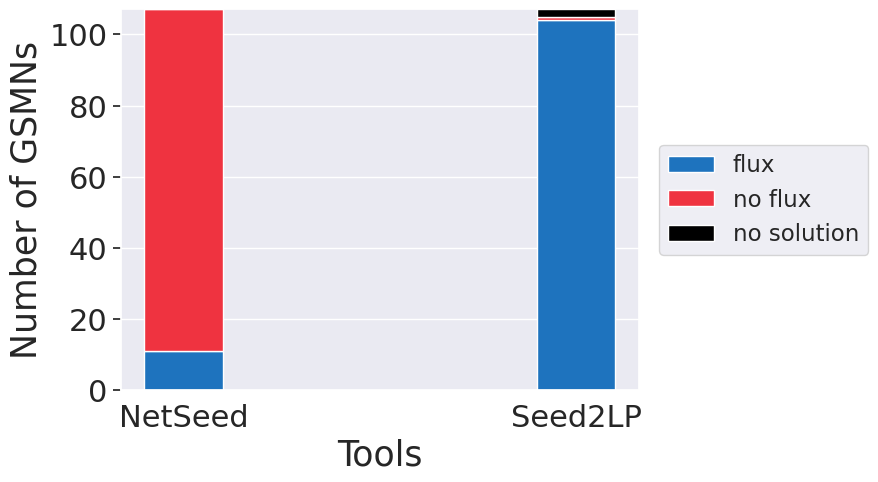

In [38]:
create_one_plot(s2lp_flux, netseed_flux, ["Seed2LP", "NetSeed"])

## Set of seed solution and scope analyses

> Notes:
>
> On the above plot, "global mean" is a mean of means per network (all solutions, up to 1000, are averaged by network, then an average of those is performed)

S2LP global mean:  89.35444227204987 	 NetSeed global mean:  30.58497220996268


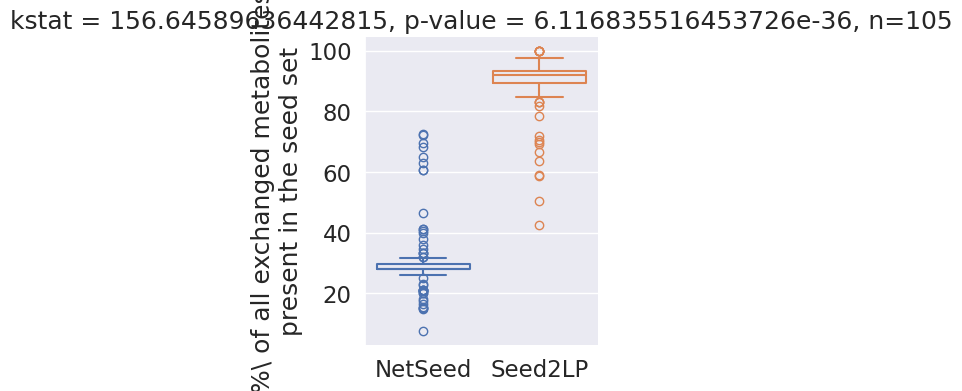

In [34]:
plot_compare(scope_s2lp, scope_netseed, 'percentage_similar_exchange_into_seeds', ["Seed2LP","NetSeed"],
             y_label="%\ of all exchanged metabolites\npresent in the seed set")

S2LP global mean:  28.184406328240268 	 NetSeed global mean:  11.503983496802025


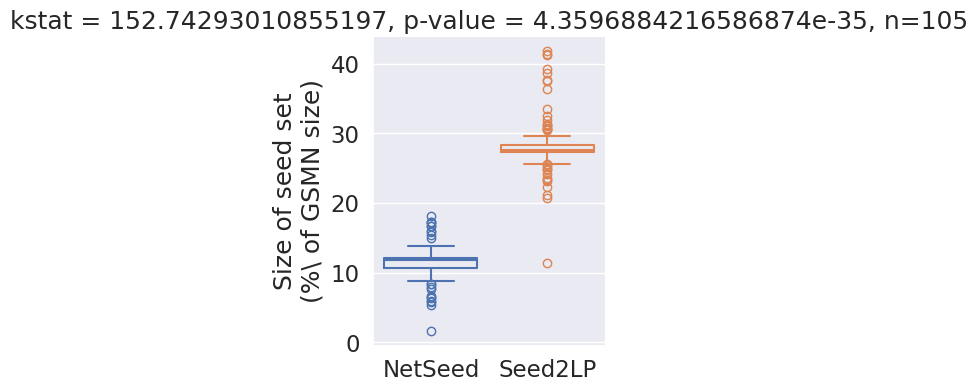

In [35]:
plot_compare(data_size_s2lp, data_size_netseed, 'percent', ["Seed2LP","NetSeed"], 
             y_label="Size of seed set\n(%\ of GSMN size)")

S2LP global mean:  100.0 	 NetSeed global mean:  69.39226789644138


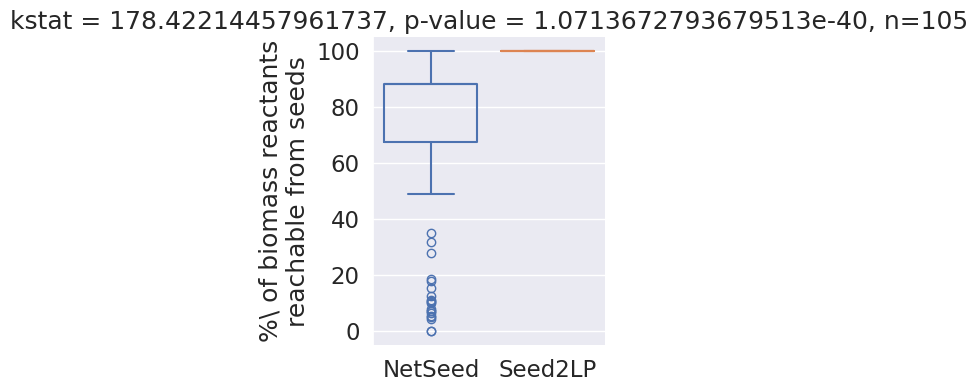

In [36]:
plot_compare(scope_s2lp, scope_netseed, 'percentage_similar_biomass', ["Seed2LP","NetSeed"], 
             y_label="%\ of biomass reactants\nreachable from seeds")

S2LP global mean:  100.0 	 NetSeed global mean:  68.64459957577657


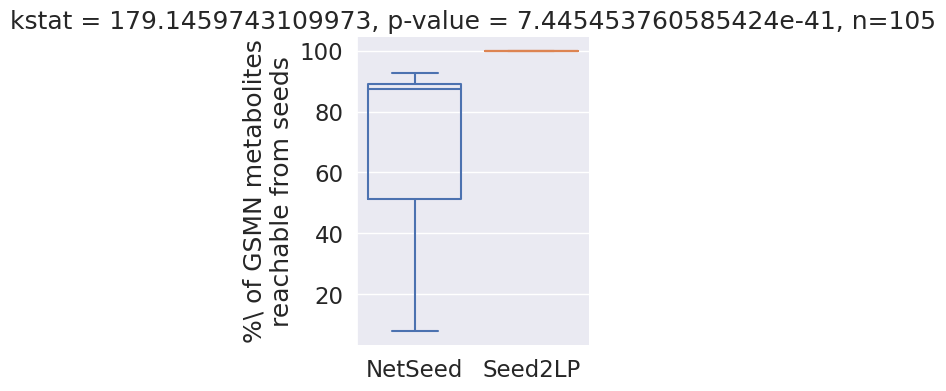

In [37]:
plot_compare(scope_s2lp, scope_netseed, 'percentage_similar', ["Seed2LP","NetSeed"], 
             y_label="%\ of GSMN metabolites\nreachable from seeds")